<a href="https://colab.research.google.com/github/Collin-Campbell/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/LS_DS_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# https://www.kaggle.com/fema/federal-disasters

df = pd.read_csv('database.csv', parse_dates=['Declaration Date'])

In [2]:
print(df.shape)
df.head()

(46185, 14)


,Declaration Number,Declaration Type,Declaration Date,State,County,Disaster Type,Disaster Title,Start Date,End Date,Close Date,Individual Assistance Program,Individuals & Households Program,Public Assistance Program,Hazard Mitigation Program
0,DR-1,Disaster,1953-05-02,GA,NaN,Tornado,Tornado,05/02/1953,05/02/1953,06/01/1954,Yes,No,Yes,Yes
1,DR-2,Disaster,1953-05-15,TX,NaN,Tornado,Tornado and Heavy Rainfall,05/15/1953,05/15/1953,01/01/1958,Yes,No,Yes,Yes
2,DR-3,Disaster,1953-05-29,LA,NaN,Flood,Flood,05/29/1953,05/29/1953,02/01/1960,Yes,No,Yes,Yes
3,DR-4,Disaster,1953-06-02,MI,NaN,Tornado,Tornado,06/02/1953,06/02/1953,02/01/1956,Yes,No,Yes,Yes
4,DR-5,Disaster,1953-06-06,MT,NaN,Flood,Floods,06/06/1953,06/06/1953,12/01/1955,Yes,No,Yes,Yes


In [6]:
df_emergencies = df['Declaration Date'].drop_duplicates()

assert len(df_emergencies) == df_emergencies.nunique()

In [7]:
df_emergencies.to_csv('emergencies.csv')

In [39]:
# https://www.kaggle.com/lsind18/daily-london-metal-fix-prices

df1 = pd.read_csv('londonfixes-current-clean_1990_.csv', 
                  parse_dates=['Date'], 
                  index_col='Date')

df2 = pd.read_csv('emergencies.csv', 
                  parse_dates=['Declaration Date'], 
                  index_col='Declaration Date')

df2['Emergency_Declared'] = 'Yes'

df2 = df2.drop(columns='Unnamed: 0')

In [40]:
print(df1.shape)
df1.head()

(7617, 7)


,Gold AM Fix,Gold PM Fix,Silver Fix,Platinum AM Fix,Platinum PM Fix,Palladium AM Fix,Palladium PM Fix
Date,,,,,,,
1990-04-02,368.00,368.40,4.9375,471.00,470.50,128.00,127.65
1990-04-03,374.80,375.00,5.0010,475.80,477.25,128.35,128.50
1990-04-04,374.25,374.25,5.0100,475.70,476.75,128.35,128.00
1990-04-05,378.10,378.40,5.1475,481.75,481.85,128.40,127.75
1990-04-06,380.35,377.70,5.1790,481.00,480.25,128.75,128.50


In [41]:
print(df2.shape)
df2.head()

(2507, 1)


,Emergency_Declared
Declaration Date,
1953-05-02,Yes
1953-05-15,Yes
1953-05-29,Yes
1953-06-02,Yes
1953-06-06,Yes


In [43]:
df_merged = pd.merge(df1, df2, left_index=True, right_index=True, how='outer')

df_merged['Emergency_Declared'].fillna(value='No', inplace=True)

df_merged.dropna(inplace=True)

df_merged = df_merged[df_merged.index < '2017-02-15']

df_merged['Percentage_Change_Gold'] = (df_merged['Gold PM Fix'] - df_merged['Gold AM Fix']) / df_merged['Gold AM Fix'] * 100

df_merged['Percentage_Change_Platinum'] = (df_merged['Platinum PM Fix'] - df_merged['Platinum AM Fix']) / df_merged['Platinum AM Fix'] * 100

df_merged['Percentage_Change_Palladium'] = (df_merged['Palladium PM Fix'] - df_merged['Palladium AM Fix']) / df_merged['Palladium AM Fix'] * 100

df_merged = df_merged[['Silver Fix', 'Gold AM Fix', 'Gold PM Fix', 'Percentage_Change_Gold', 
         'Platinum AM Fix', 'Platinum PM Fix', 'Percentage_Change_Platinum', 
         'Palladium AM Fix', 'Palladium PM Fix', 'Percentage_Change_Palladium', 
         'Emergency_Declared']]

df_merged = df_merged.drop(['Silver Fix', 'Gold AM Fix', 'Gold PM Fix',
                           'Platinum AM Fix', 'Platinum PM Fix', 'Palladium AM Fix', 
                           'Palladium PM Fix'], axis=1)

In [44]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6728 entries, 1990-04-02 to 2017-02-14
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Percentage_Change_Gold       6728 non-null   float64
 1   Percentage_Change_Platinum   6728 non-null   float64
 2   Percentage_Change_Palladium  6728 non-null   float64
 3   Emergency_Declared           6728 non-null   object 
dtypes: float64(3), object(1)
memory usage: 262.8+ KB


In [45]:
print(df_merged.shape)
df_merged.head()

(6728, 4)


,Percentage_Change_Gold,Percentage_Change_Platinum,Percentage_Change_Palladium,Emergency_Declared
1990-04-02,0.108696,-0.106157,-0.273437,No
1990-04-03,0.053362,0.304750,0.116868,Yes
1990-04-04,0.000000,0.220727,-0.272692,No
1990-04-05,0.079344,0.020758,-0.506231,No
1990-04-06,-0.696727,-0.155925,-0.194175,No


In [46]:
6728 * 0.80

5382.400000000001

In [47]:
df_merged.index[5382]

Timestamp('2011-10-03 00:00:00')

In [48]:
# Splitting into target and feature matrix

target = 'Emergency_Declared'

y = df_merged[target]
X = df_merged.drop(columns=target)

In [49]:
# Splitting into training and test sets:

cutoff = '2011-10-03'
mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [50]:
assert len(X_train) + len(X_test) == len(X)

In [51]:
# Establishing baseline (classification problem, so majority class)

baseline_acc = y_train.value_counts(normalize=True).max()

print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.771832032701598


In [87]:
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

# Building model pipeline

XGB_model = make_pipeline(
      XGBClassifier(random_state=42, n_jobs=-1, n_estimators=500, max_depth=3)
      )

In [88]:
XGB_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=500, n_jobs=-1, nthread=None,
                               objective='binary:logistic', random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

In [89]:
# Checking metrics

print('XGB: Training Accuracy:', XGB_model.score(X_train, y_train))
print('XGB: Testing Accuracy:', XGB_model.score(X_test, y_test))

XGB: Training Accuracy: 0.8028613898179116
XGB: Testing Accuracy: 0.8046062407132244


In [91]:
# Determining Permutation Importance

from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(XGB_model, X_test, y_test, n_jobs=10, random_state=42)

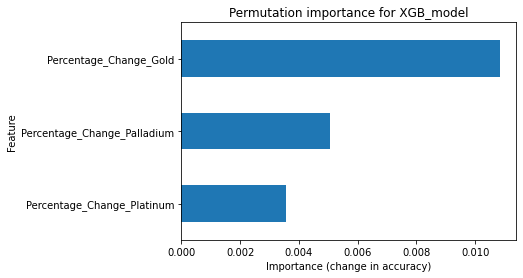

In [93]:
import matplotlib.pyplot as plt


# Putting results into DataFrame
data = {'importances_mean' : perm_imp['importances_mean'],
        'importances_std' : perm_imp['importances_std']}

df = pd.DataFrame(data, index=X_test.columns)
df.sort_values('importances_mean', ascending=True, inplace=True)

# Making a plot
df['importances_mean'].tail(10).plot(kind='barh')
plt.xlabel('Importance (change in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for XGB_model');